서론
- 시계열 데이터에서 시간적으로 멀리 떨어진, 장기의존관계를 잘 학습할 수 없다.
- LSTM, GRU
- gate. 이를 통해 장기 의존 관계를 학습할 수 있음

# 6.1 RNN의 문제점
- 장기 의존 관계를 학습하기 어렵다.
- BPTT에서 기울기 소실 혹은 기울기 폭발이 일어나기 때문에. 

## 6.1.1 RNN 복습

<img src="../../../data/deep_learning_2_images/fig 6-1.png" width="600">

- 이전 시각의 은닉 상태를 이용한다.

<img src="../../../data/deep_learning_2_images/fig 6-2.png" width="400">


## 6.1.2 기울기 소실 또는 기울기 폭발

<img src="../../../data/deep_learning_2_images/fig 6-3.png" width="500">
<img src="../../../data/deep_learning_2_images/fig 6-4.png" width="500">

- RNN 계층이 과거 방향으로 의미 있는 기울기를 전달함으로써 시간 방향의 의존 관계를 학습할 수 있다.
- 기울기에는 학습해야할 의미있는 정보가 들어있고, 이를 과거로 전달함으로써 장기 의존 관계를 학습한다.
- 기울기가 중간에 사그라들면(정보가 없어지면) 가중치 매개변수는 전혀 갱신이 안됨
- 현재의 단순한 RNN 계층에서는 시간을 거슬러 올라갈수록 기울기가 작아지거나(기울기 소실) 혹은 커질 수 있으며 (기울기 폭발), 대부분 둘 중 하나의 운명을 걷게 된다.

## 6.1.3 기울기 소실과 기울기 폭발의 원인

<img src="../../../data/deep_learning_2_images/fig 6-5.png" width="600">


<img src="../../../data/deep_learning_2_images/fig 6-6.png" width="400"> 

- $y = tanh(x)$의 미분은 $\frac{\partial y}{\partial x} = 1 - y^2$
  - 0~1사이의 값, 지날 때마다 값이 작아짐
  - ReLU를 통해 기울기 소실을 줄일 수 있음. 



<img src="../../../data/deep_learning_2_images/fig 6-7.png" width="500"> 

- 매번 똑같은 가중치 $W_h$가 사용된다.
  - $W_h$ > 1
    - 기울기 폭발 (exploding gradients) -> Overflow
  - $W_h$ < 1
    - 기울기 소실 (vanishing gradients) , 학습 안됨 -> 장기의존관계 학습 불가능
  - $W_h$가 스칼라가 아니라 행렬이라면?
    - 행렬의 '특잇값'이 척도가 됨 (데이터가 얼마나 퍼져 있는지)
    - 여러 특잇값 중 최댓값이 1보다 큰지 여부 -> 어떻게 변할지 예측 가능

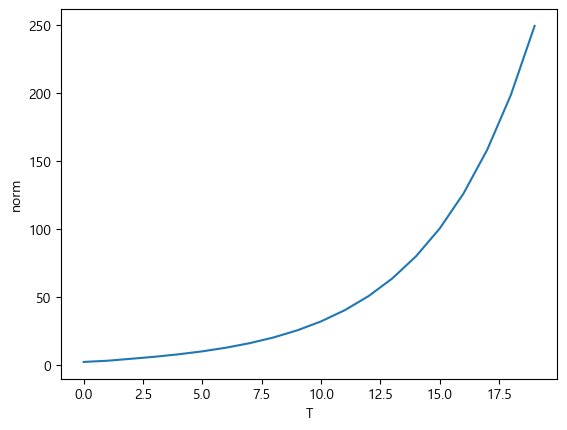

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic') # For Windows

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
  dh = np.matmul(dh, Wh.T)
  norm = np.sqrt(np.sum(dh ** 2)) / N
  norm_list.append(norm)
  
plt.plot(norm_list)
plt.xlabel('T')
plt.ylabel('norm')

plt.show()

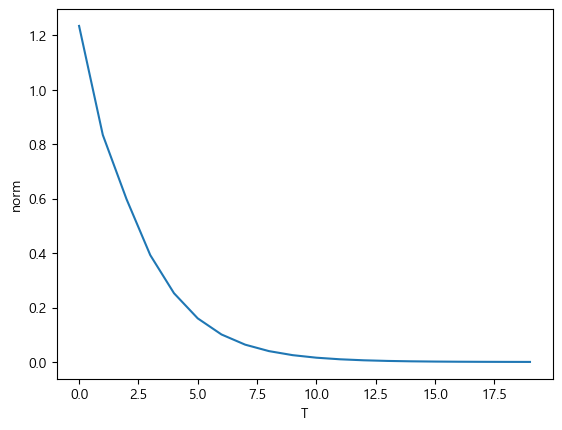

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic') # For Windows

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
  dh = np.matmul(dh, Wh.T)
  norm = np.sqrt(np.sum(dh ** 2)) / N
  norm_list.append(norm)
  
plt.plot(norm_list)
plt.xlabel('T')
plt.ylabel('norm')

plt.show()

## 6.1.4 기울기 폭발 대책
- 기울기 클리핑 , gradients clipping

$if ||\hat g|| \geq threshold: \hat g = \frac{threshold}{||\hat g||}\hat g$

In [6]:
import numpy as np

dW1 = np.random.randn(3, 3) * 10
dW2 = np.random.randn(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
  total_norm = 0
  for grad in grads:
    total_norm += np.sum(grad ** 2)
  total_norm = np.sqrt(total_norm)
  
  rate = max_norm / (total_norm + 1e-6)
  if rate < 1:
    for grad in grads:
      grad *= rate



# 6.2 기울기 소실과 LSTM
- 게이트가 추가된 RNN
- 많은 아키텍쳐, LSTM과 GRU가 대표격

## 6.2.1 LSTM의 인터페이스
<img src="../../../data/deep_learning_2_images/fig 6-10.png" width="600"> 

- tanh 직사각형 노드 -> $tanh(h_{t-1}W_h + x_tW_x + b)$

<img src="../../../data/deep_learning_2_images/fig 6-11.png" width="700"> 

- c : 기억 셀 (memory cell)
  - 데이터를 자기 자신으로만(LSTM 계층 내에서만) 주고 받음
  - LSTM 계층 내에서만 완결되고, 다른 계층으로는 출력하지 않음
- h : 은닉상태 
  - RNN 계층과 마찬가지로 다른 계층으로 출력됨

## 6.2.2 LSTM 계층 조립하기

<img src="../../../data/deep_learning_2_images/fig 6-12.png" height="300"> 

- $c_t$
  - 시각 t에서의 LSTM의 기억이 저장되어있음
  - 과거로부터 시각 t까지에 필요한 모든 정보가 저장돼 있다고 가정 (또는 그렇게 되도록 학습)
- $h_t$
  - $c_t$를 바탕으로 외부 계층에 은닉 상태 $h_t$를 출력
  - 기억셀의 값을 $tanh$함수로 변환한 값
  - $h_t = tanh(c_t)$
- 입력 ($c_{t-1}, h_{t-1}, x_t$)으로부터 '어떤 계산'을 수행
- 갱신된 $c_t$를 사용해 $h_t$를 계산한다.  

- 게이트
  - 데이터의 흐름을 제어

<img src="../../../data/deep_learning_2_images/fig 6-13.png" height="200"> 

- LSTM에서 사용하는 게이트는 '열기/닫기'뿐만 아니라, 어느 정도 열지를 조절할 수 있다.
- 다음 단계로 흘려보낼 물의 양을 제어

<img src="../../../data/deep_learning_2_images/fig 6-14.png" height="200"> 

- 게이트의 열림 상태는 0.0~1.0 사이의 실수
- '게이트를 얼마나 열까'라는 것도 데이터로부터 자동으로 학습한다


## 6.2.3 output 게이트

- $tanh(c_t)$에 게이트를 적용하는 것
- $tanh(c_t)$의 각 원소에 대해 '그것이 다음 시각의 은닉 상태에 얼마나 중요한가'를 조정
- 다음 은닉 상태 $h_t$의 출력을 담당하는 게이트이므로 ouput 게이트라 한다.

- output 게이트의 열림상태는 입력 $x_t$와 이전 상태 $h_{t-1}$로부터 구한다. 

<img src="../../../data/deep_learning_2_images/e 6-1.png" height="50"> 

<img src="../../../data/deep_learning_2_images/fig 6-15.png" height="400"> 

- 아다마르 곱 Hadamard product , 원소별 곱
- $h_t = o \odot tanh(c_t)$

- tanh의 출력은 -1.0~1.0의 실수. 이를 그 안에 인코딩된 '정보'의 강약(정도)를 표시한다고 해석할 수 있다.
- 시그모이드 함수의 출력은 0.0~1.0사이의 실수. 데이터를 얼마나 통과시킬지를 정하는 비율
- 게이트에서는 시그모이드 함수가, 실질적인 정보를 지니는 데이터에는 tanh가 활성화 함수로 사용됨

## 6.2.4 forget 게이트
- 망각은 더 나은 전진을 낳는다.
- 기억 셀에 '무엇을 잊을까'를 명확하게 지시하는 것

<img src="../../../data/deep_learning_2_images/fig 6-16.png" height="300"> 

- $f = \sigma(x_t W_x^{(f)} + h_{t-1}W_b^{(f)} + b^{(f)}$)
- $c_t = f \odot c_{t-1}$

## 6.2.5 새로운 기억셀
- 새로 기억해야 할 정보를 기억 셀에 추가

<img src="../../../data/deep_learning_2_images/e 6-4.png" height="50"> 
<img src="../../../data/deep_learning_2_images/fig 6-17.png" height="400"> 


## 6.2.6 input 게이트

- g의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단
- 새 정보를 무비판적으로 수용하는게 아니라, 적절히 취사선택하는 것이 이 게이트의 역할
- input 게이트에 의해 가중된 정보가 새로 추가되는 셈

<img src="../../../data/deep_learning_2_images/e 6-5.png" height="50"> 
<img src="../../../data/deep_learning_2_images/fig 6-18.png" height="400"> 


## 6.2.7 LSTM의 기울기 흐름

- 기억 셀의 역전파에는 '+'와 'x'노드만을 지나게 됨.
  - '+'는 그대로
  - 'x'는 행렬곱이 아닌 원소별 곱(아마다르 곱) 
  - 매 시각 다른 게이트 값을 이용해 곱함. 
    - 곱셈의 효과가 누적되지 않아 기울기 소실이 일어나기 어려운 구조
- forget 게이트. 잊어야 한다고 판단한 것에 대해 기울기를 작게함
  - 오래 기억해야 할 정보일 경우 소실없이 전파되리라 기대할 수 있다. 

<img src="../../../data/deep_learning_2_images/fig 6-19.png" height="200"> 


# 6.3 LSTM 구현

관련 수식들

<img src="../../../data/deep_learning_2_images/e 6-6.png" height="150"><br/>
<img src="../../../data/deep_learning_2_images/e 6-7.png" height="30"><br/>
<img src="../../../data/deep_learning_2_images/e 6-8.png" height="30"><br/>

- 네 수식 모두 아핀변환, affine tranformation
  - 행렬 변환과 평행 이동(편향)을 결합한 형태
- 하나의 식으로 정리해 계산 가능

<img src="../../../data/deep_learning_2_images/fig 6-20.png" height="400"> 
<img src="../../../data/deep_learning_2_images/fig 6-21.png" height="400"> 


In [ ]:
class LSTM:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b] # 4개분의 가중치가 담겨 있음
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None # 역전파 때 사용하기 위함
    
  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape
    
    A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b # affine transformation
    
    # slice
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]
    
    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)
    
    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)
    
    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

수식 형상 

<img src="../../../data/deep_learning_2_images/fig 6-22.png" height="300"> 
<img src="../../../data/deep_learning_2_images/fig 6-23.png" height="300"> 

## 6.3.1 Time LSTM 구현

<img src="../../../data/deep_learning_2_images/fig 6-24.png" height="200"> 
<img src="../../../data/deep_learning_2_images/fig 6-25.png" height="200"> 

In [7]:
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b] 
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None
    self.h, self.c = None
    self.dh = None
    self.stateful = stateful

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]
    
    self.layers = []
    hs = np.empty((N, T, H), dtype='f')
    
    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype='f')
    
    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h
      
      self.layers.append(layer)
      
    return hs
  
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]
    
    dxs = np.empty((N, T, D), dtype='f')
    dh, dc = 0, 0
    
    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t, :] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad
        
    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
      
    self.dh = dh
      
    return dx
      
  def set_state(self, h, c=None):
    self.h, self.c = h, c
    
  def reset_state(self):
    self.h, self.c = None, None

# 6.4 LSTM을 사용한 언어모델

<img src="../../../data/deep_learning_2_images/fig 6-26.png" height="400"> 

In [ ]:
import sys
sys.path.append('../../modules/Part2/')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


# 6.5 RNNLM 추가 개선

## 6.5.1 LSTM 계층 다층화

- LSTML 계층을 깊게 쌓아 효과를 볼 수 있다.
- 더 복잡한 패턴을 학습할 수 있게 됨
- 구글 번역에서 사용하는 GNMT 모델은 LSTM을 8층이나 쌓은 신경망
- 처리할 문제가 복잡하고 학습 데이터를 대량으로 준비할 수 있다면 LSTM 계층을 깊게 쌓는 것이 정확도 향상을 이끌 수도 있다.

<img src="../../../data/deep_learning_2_images/fig 6-29.png" height="500"> 

## 6.5.2 드롭아웃에 의한 과적합 억제

- RNN은 일반적인 피드포워드 신경망보다 쉽게 과적합을 일으킨다.
- 과적합 억제
  - 훈련 데이터의 양 늘리기
  - 모델의 복잡도 줄이기
  - 정규화
  - 드롭아웃 , 무작위로 무시

<img src="../../../data/deep_learning_2_images/fig 6-30.png" height="200">
<img src="../../../data/deep_learning_2_images/fig 6-31.png" height="300">
<img src="../../../data/deep_learning_2_images/fig 6-32.png" height="150">
<img src="../../../data/deep_learning_2_images/fig 6-33.png" height="300">

- 시계열 방향으로 드롭아웃을 넣게 되면 시간이 흐름에 따라 정보가 사라질 수 있다.
  - 흐르는 시간에 비례해 드롭아웃에 의한 노이즈가 축적됨

- 일반적인 드롭아웃은 시간 방향에는 적합하지 않음
  - RNN의 시간 방향 정규화를 목표로 하는 방법이 다양하게 제안됨
- 변형 드롭아웃, Variational Dropout
  - 시간방향으로 적용하는데 성공함
  - 깊이 방향은 물론 시간 방향에도 이용할 수 있어 언어 모델의 정확도를 한 층 더 향상시킴
  - 같은 마스크를 공유
  - 일반 드롭아웃보다 결과가 좋다고 알려짐

<img src="../../../data/deep_learning_2_images/fig 6-34.png" height="300">


## 6.5.3 가중치 공유, weight tying

<img src="../../../data/deep_learning_2_images/fig 6-35.png" height="400">

- Embedding 계층의 가중치와 Affine 계층의 가중치를 연결하는 기법
- 두 계층이 가중치를 공유함으로써 학습하는 매개변수 수가 크게 줄어드는 동시에 정확도도 향상되는 일석이조의 기술
- Embedding - VxH / Affine - HxV 
- 매개변수 수가 줄어듬 -> 과적합이 억제되는 혜택


## 6.5.4 개선된 RNNLM 구현
<img src="../../../data/deep_learning_2_images/fig 6-36.png" height="600">

- LSTM 계층의 다층화(여기서는 2층)
- 드롭아웃 사용(깊이 방향으로만 적용)
- 가중치 공유 (Embedding 계층과 Affine 계층에서 가중치 공유)


In [ ]:
import sys
sys.path.append('../../modules/Part2/')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
  def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn
    
    embed_W = (rn(V, D) / 100).astype('f') # embedding과 affine 계층의 가중치를 공유함
    lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
    lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
    lstm_b1 = np.zeros(4 * H).astype('f')
    lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(D)).astype('f')
    lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
    lstm_b2 = np.zeros(4 * H).astype('f')
    affine_b = np.zeros(V).astype('f')
    
    self.layers = [
      TimeEmbedding(embed_W),
      TimeDropout(dropout_ratio), # dropout 적용
      TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1), 
      TimeDropout(dropout_ratio),
      TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2), # lstm 계층 다층화
      TimeDropout(dropout_ratio),
      TimeAffine(embed_W.T, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layers = [self.layers[2], self.layers[4]]
    self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
    
    self.params, self.grads = []